# Predict pseudobulks

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-08 17:41:03.297887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 17:41:03.298375: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 17:41:03.301080: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 17:41:03.307251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736383263.316860 2531563 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736383263.31

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE165897_pseudobulks/"
consensus_ov_gene_path = f"{os.getcwd()}/../../data/consensusOV_genes.csv"


exp_id = "all-granular"
res_id = "granular"
curr_treatment = "drug"

in_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"

subtype_file = f"{sc_aug_data_path}/{exp_id}_subtypes.tsv"


In [3]:
adata = sc.read_h5ad(in_ad_file)

subtype_df = pd.read_csv(subtype_file, sep="\t")

if res_id == "subtype":
    adata.obs = adata.obs.rename({'IMR':'scIMR', 'DIF':'scDIF', 'PRO':'scPRO', 'MES':'scMES'}, axis=1)
    cell_types = ["scIMR", "scDIF", "scPRO", "scMES"]
elif res_id == "cellType":
    cell_types = ["EOC", "Stromal", "Immune"]
else: # granular
    cell_types = ["immune", "stromal", "tumor"]



In [4]:
# append to obs they should be in exactly the same order
subtype_df.index = adata.obs.index
adata.obs = pd.concat([adata.obs, subtype_df], axis=1)

In [5]:

Y_full = adata.obs[cell_types]
Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
adata.obs["Y_max"] = Y_max

In [6]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,tumor,stromal,immune,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max
0,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.110000,0.415000,0.475000,0.166,0.062,0.288,0.484,MES,immune
1,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.790000,0.195000,0.015000,0.066,0.134,0.688,0.112,PRO,tumor
2,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.030000,0.955000,0.015000,0.042,0.066,0.384,0.508,MES,stromal
3,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.065000,0.065000,0.870000,0.512,0.104,0.126,0.258,IMR,immune
4,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.655000,0.330000,0.015000,0.040,0.110,0.746,0.104,PRO,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27295,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.000981,0.001481,0.997538,0.748,0.130,0.030,0.092,IMR,immune
27296,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.010363,0.010970,0.978667,0.708,0.168,0.040,0.084,IMR,immune
27297,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.002247,0.039699,0.958053,0.652,0.160,0.050,0.138,IMR,immune
27298,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.001144,0.012687,0.986168,0.726,0.118,0.034,0.122,IMR,immune


# Plot

In [7]:
sc.tl.pca(adata, n_comps=50)


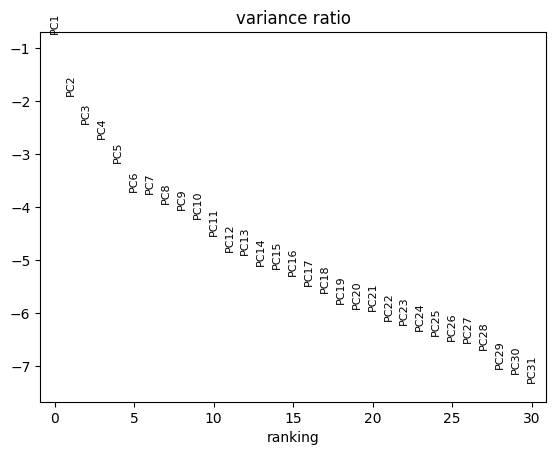

In [8]:
sc.pl.pca_variance_ratio(adata, log=True)


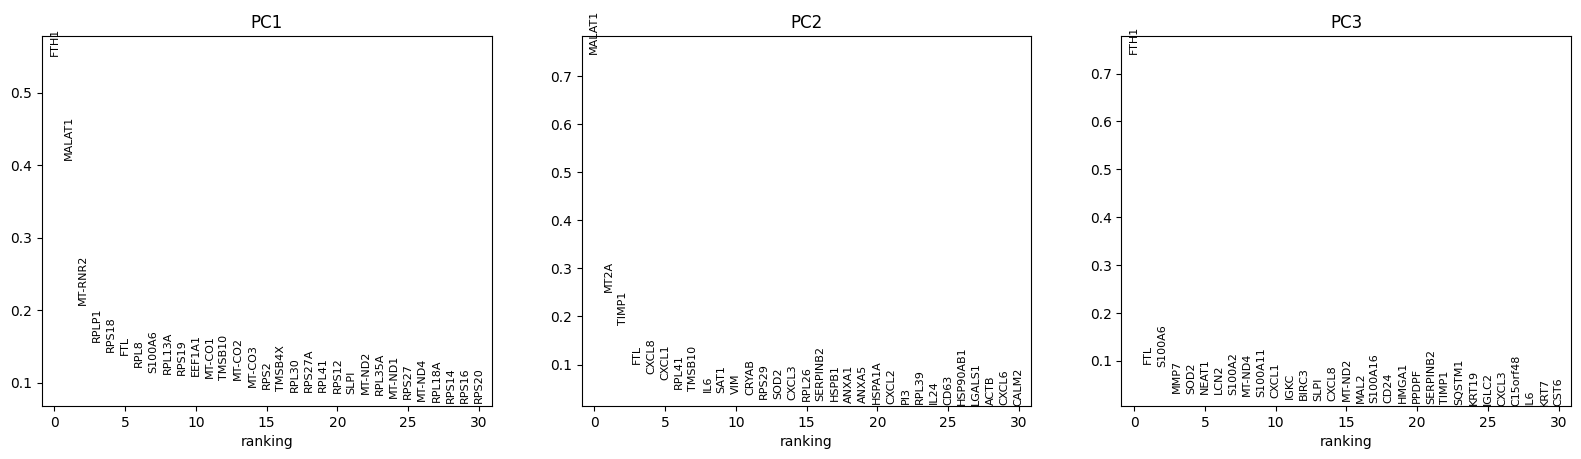

In [9]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [10]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


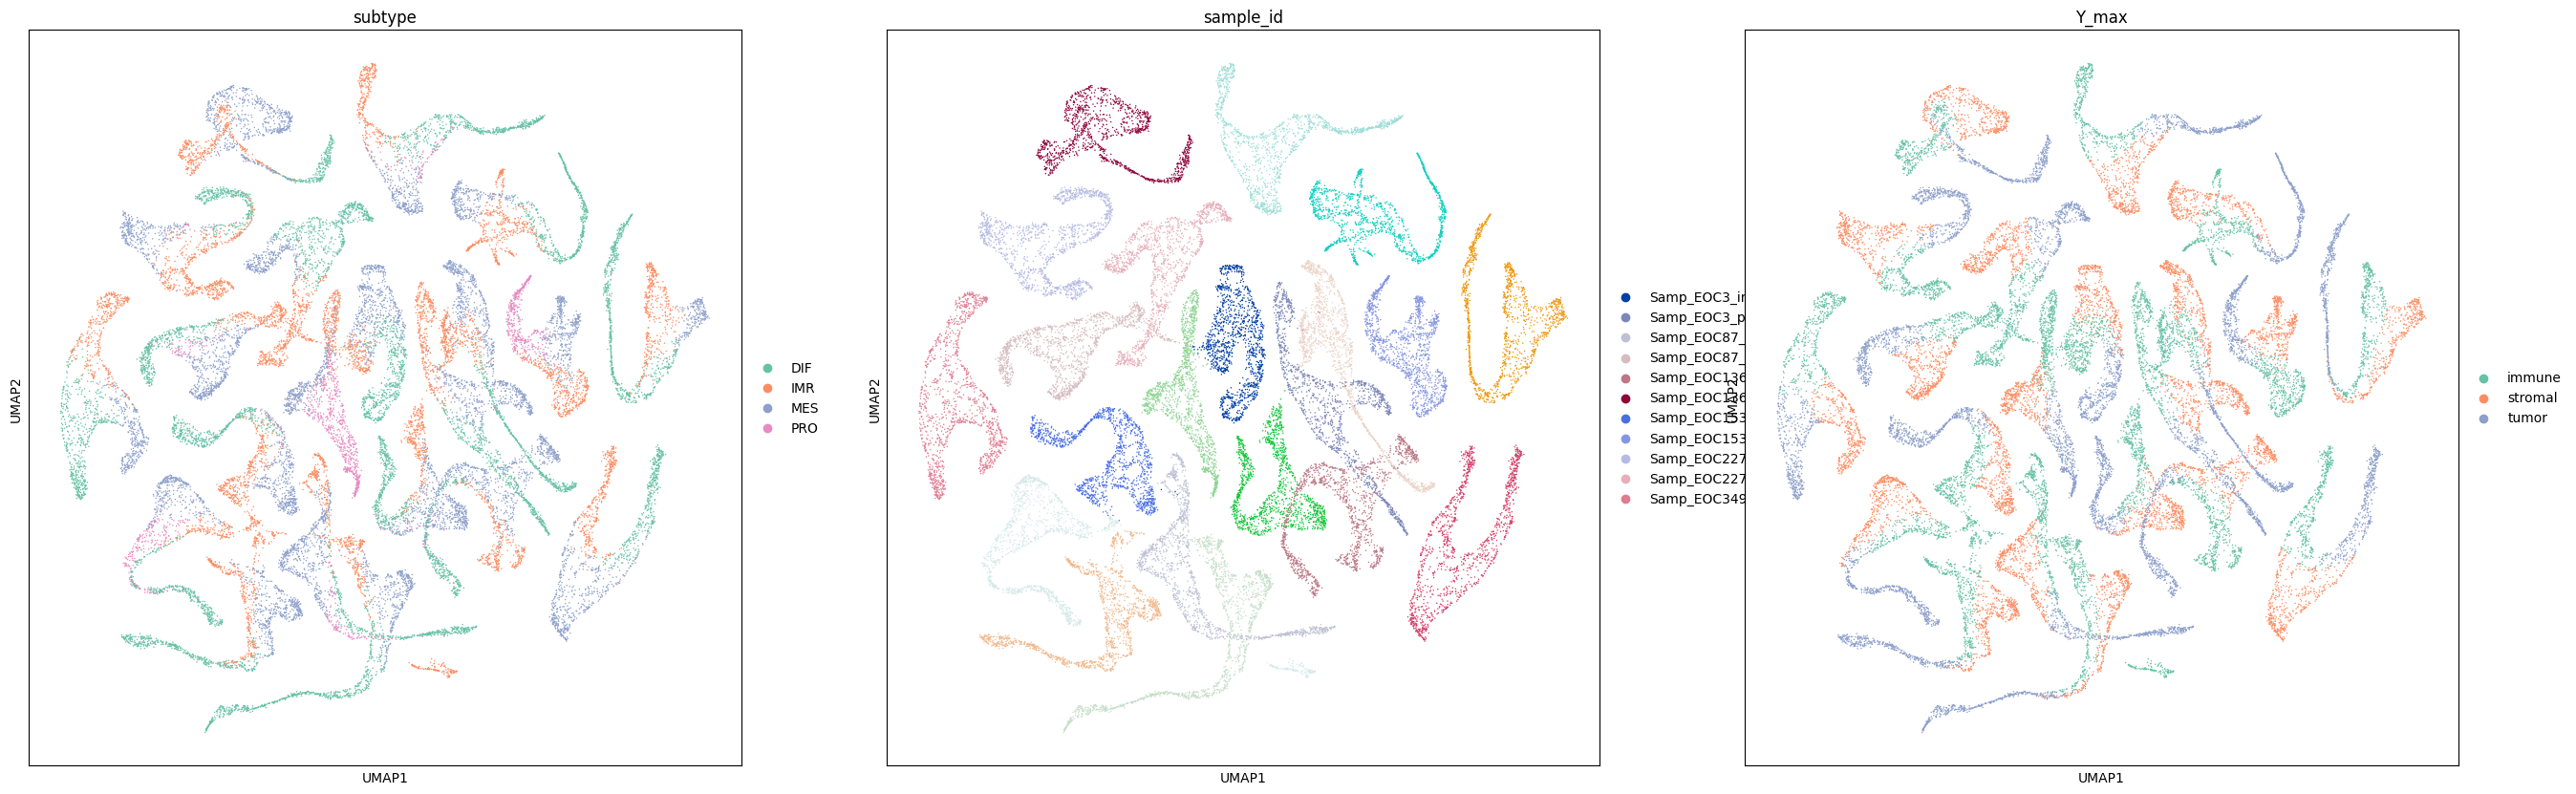

In [11]:
from matplotlib.pyplot import rc_context

# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color=['subtype', 'sample_id', "Y_max"])


In [12]:
tab = adata.obs.groupby(['Y_max', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
Y_max,,,,
immune,788,7088,1096,147
stromal,731,194,7699,494
tumor,7403,278,268,1114


In [13]:
tab = adata.obs.groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_EOC3_interval_Omentum,547,209,544,0
Samp_EOC3_primary_Peritoneum,457,354,489,0
Samp_EOC87_interval_Omentum,416,238,524,122
Samp_EOC87_primary_Peritoneum,418,316,491,75
Samp_EOC136_interval_Omentum,335,318,635,12
Samp_EOC136_primary_Mesentery,261,420,619,0
Samp_EOC153_interval_Omentum,463,385,413,39
Samp_EOC153_primary_Omentum,3,409,442,446
Samp_EOC227_interval_Omentum,355,577,347,21


In [14]:
set(adata.obs.Y_max)

{'immune', 'stromal', 'tumor'}

In [15]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "tumor")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_EOC3_interval_Omentum,435,0,4,0
Samp_EOC3_primary_Peritoneum,408,0,12,0
Samp_EOC87_interval_Omentum,366,0,0,84
Samp_EOC87_primary_Peritoneum,385,0,4,48
Samp_EOC136_interval_Omentum,312,6,100,12
Samp_EOC136_primary_Mesentery,261,74,97,0
Samp_EOC153_interval_Omentum,438,23,3,12
Samp_EOC153_primary_Omentum,3,33,2,387
Samp_EOC227_interval_Omentum,338,105,0,5


# set the label for Diff Exp

In [16]:
# set the label

cell_type_vec = np.array(["DIF_total"]*adata.obs.sample_id.shape[0])
pro_label_idx = np.where(adata.obs.sample_id.isin(["Samp_EOC136_primary_Mesentery", "Samp_EOC372_primary_Peritoneum"]) )[0]
cell_type_vec[pro_label_idx] = "PRO_total"

adata.obs['subtype_total'] = cell_type_vec



In [17]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "immune")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_EOC3_interval_Omentum,95,209,125,0
Samp_EOC3_primary_Peritoneum,30,353,60,0
Samp_EOC87_interval_Omentum,49,238,123,14
Samp_EOC87_primary_Peritoneum,32,316,78,9
Samp_EOC136_interval_Omentum,23,312,115,0
Samp_EOC136_primary_Mesentery,0,346,59,0
Samp_EOC153_interval_Omentum,7,356,27,1
Samp_EOC153_primary_Omentum,0,376,65,10
Samp_EOC227_interval_Omentum,1,414,1,0


In [18]:
immune_ct = ["stromal"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_EOC3_interval_Omentum,0,0,100,0
Samp_EOC3_primary_Peritoneum,0,0,100,0
Samp_EOC87_interval_Omentum,0,0,100,0
Samp_EOC87_primary_Peritoneum,0,0,100,0
Samp_EOC136_interval_Omentum,0,0,100,0
Samp_EOC136_primary_Mesentery,0,0,100,0
Samp_EOC153_interval_Omentum,0,0,100,0
Samp_EOC153_primary_Omentum,0,0,100,0
Samp_EOC227_interval_Omentum,0,0,100,0


# Differential Expression

In [19]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# log data
sc.pp.log1p(adata)

# get high variance genes
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# now process the counts further for doing  
# analysis and the cell clustering
#adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=10)

# calculate PCA
sc.tl.pca(adata, n_comps=20)

# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


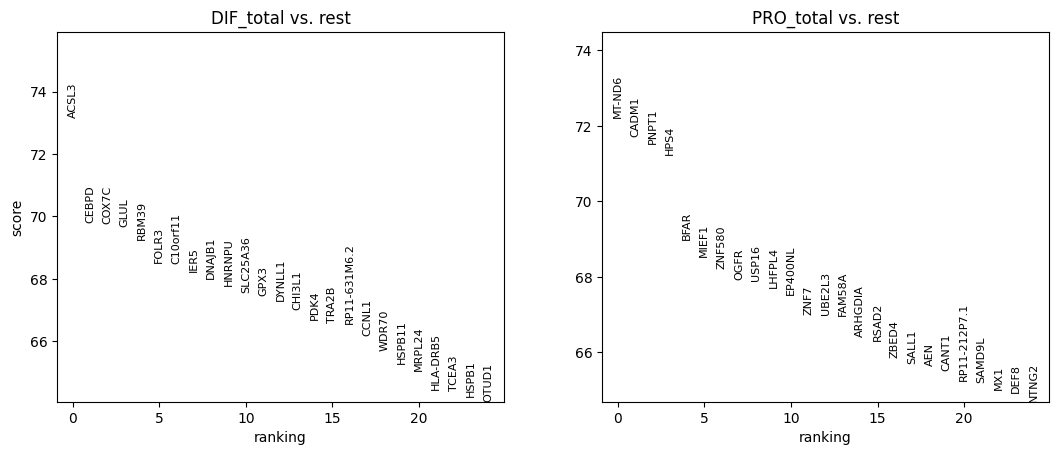

In [20]:
sc.tl.rank_genes_groups(adata, 'subtype_total', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

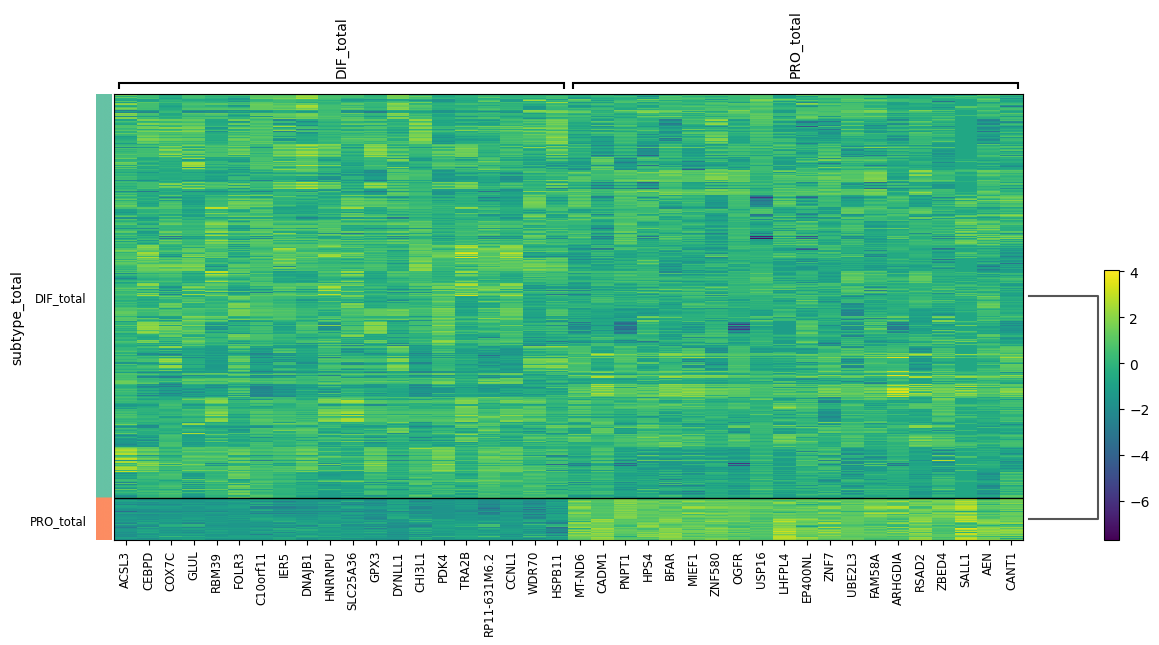

In [23]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=20, key="wilcoxon", groupby="subtype_total", show_gene_labels=True)


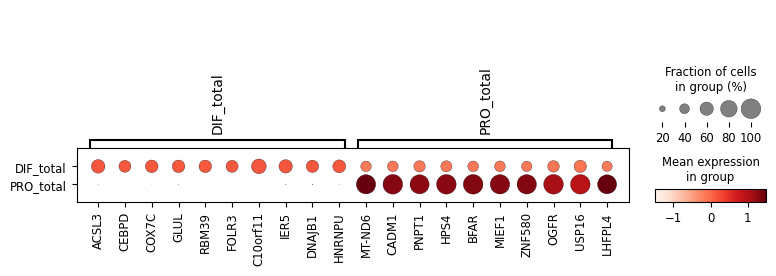

In [26]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key="wilcoxon", groupby="subtype_total")


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


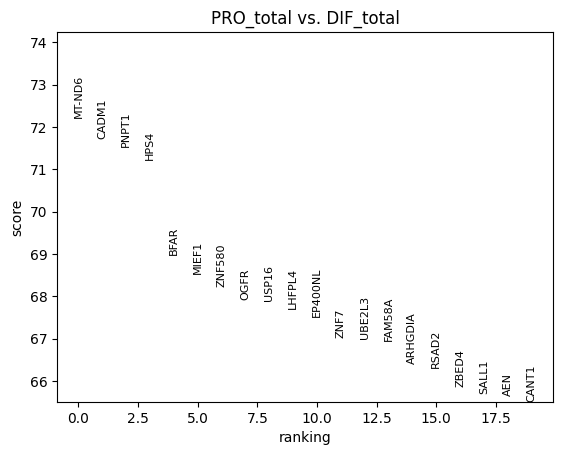

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


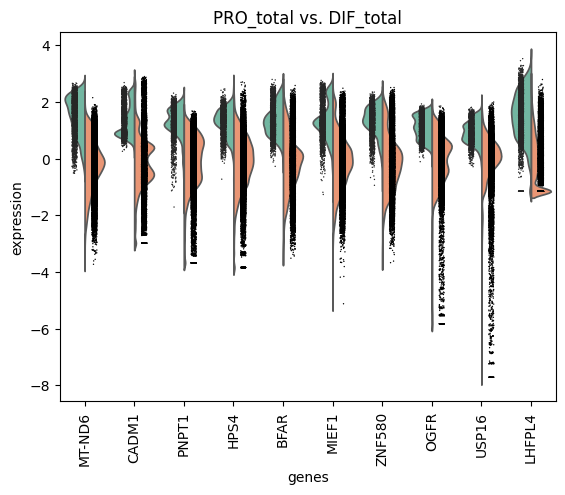

In [32]:
sc.tl.rank_genes_groups(adata, 'subtype_total', groups=['PRO_total'], reference='DIF_total', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['PRO_total'], n_genes=20)
sc.pl.rank_genes_groups_violin(adata, groups='PRO_total', n_genes=10)


In [36]:
wc = adata.uns['wilcoxon']['names']["PRO_total"]
wc[0:100]

array(['MT-ND6', 'CADM1', 'PNPT1', 'HPS4', 'BFAR', 'MIEF1', 'ZNF580',
       'OGFR', 'USP16', 'LHFPL4', 'EP400NL', 'ZNF7', 'UBE2L3', 'FAM58A',
       'ARHGDIA', 'RSAD2', 'ZBED4', 'SALL1', 'AEN', 'CANT1',
       'RP11-212P7.1', 'SAMD9L', 'MX1', 'DEF8', 'NTNG2', 'ARL16',
       'C19orf66', 'USP3', 'TMEM123', 'CMPK2', 'ZNF696', 'HSPA13',
       'IFNAR2', 'SAMD9', 'ZNF655', 'SIRT7', 'PLEKHM1P1', 'PRLR', 'SRP72',
       'PML', 'BIRC2', 'RPP14', 'RPS19BP1', 'CREG2', 'NT5C3B', 'RNF157',
       'RP11-803D5.4', 'WNT7B', 'CXorf40B', 'RPSAP52', 'CLN6', 'SEMA3A',
       'TCERG1L', 'TMEM184B', 'XXbac-BPG283O16.9', 'MMP13',
       'RP11-407G23.2', 'CDK6', 'MURC', 'NETO2', 'H19', 'RP11-604N13.1',
       'EIF2AK2', 'EWSR1', 'RC3H2', 'TMEM192', 'SNRPA1', 'RPS11P5',
       'PSMA6P1', 'PRPSAP1', 'TMEM185A', 'ZNF707', 'RP11-585P4.5',
       'UBE2J2', 'RPL21P18', 'AC002117.1', 'ZKSCAN1', 'USP36', 'APOL6',
       'ZSCAN2', 'OXLD1', 'RP11-1348G14.8', 'EI24', 'EIF3D', 'PPARA',
       'CBLN2', 'TRMU', 'ASAP1',

# Plot results

In [ ]:
# get consensusOV genes
consensus_genes = pd.read_csv(consensus_ov_gene_path)
consensus_genes = np.intersect1d(consensus_genes.gene, adata.var.gene_ids)
consensus_genes

adata = adata[:, consensus_genes]


array(['ADAMDEC1', 'ANXA1', 'APOBEC3G', 'BLMH', 'CACNA1C', 'CALD1',
       'CASP1', 'CLU', 'COL4A6', 'COL5A1', 'COL8A1', 'COPS3', 'CXCL10',
       'DDR2', 'DLC1', 'DLEC1', 'EFS', 'EVI2A', 'F2R', 'FCER1G', 'FN1',
       'FSCN1', 'FUT2', 'GAS7', 'GIMAP5', 'IL21R', 'KIF1A', 'KMO', 'LAG3',
       'LAMB1', 'LAPTM5', 'LCN2', 'LGALS1', 'MAPRE1', 'MAPRE2', 'MARCKS',
       'MARCKSL1', 'MFAP2', 'MGLL', 'MLPH', 'MMP14', 'NBL1', 'NETO2',
       'NNMT', 'NUAK1', 'PALLD', 'PCOLCE', 'PDPN', 'PDZK1IP1', 'PKIA',
       'PTGER2', 'RARRES3', 'RHOBTB3', 'RIN1', 'RUNX1', 'SALL2',
       'SCGB2A2', 'SLA', 'SLC31A2', 'SLC37A1', 'SMARCD1', 'SSH3',
       'STEAP3', 'STMN1', 'TCF7L1', 'TNFRSF14', 'TPST1', 'UBE2L6',
       'WIPF1'], dtype=object)

In [25]:
len(consensus_genes)

69

In [27]:
adata

AnnData object with n_obs × n_vars = 27300 × 69
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'tumor', 'stromal', 'immune', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'subtype_total'
    var: 'gene_ids', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'subtype_colors', 'sample_id_colors', 'Y_max_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [28]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,tumor,stromal,immune,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,subtype_total
0,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.110000,0.415000,0.475000,0.166,0.062,0.288,0.484,MES,immune,PRO_total
1,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.790000,0.195000,0.015000,0.066,0.134,0.688,0.112,PRO,tumor,PRO_total
2,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.030000,0.955000,0.015000,0.042,0.066,0.384,0.508,MES,stromal,PRO_total
3,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.065000,0.065000,0.870000,0.512,0.104,0.126,0.258,IMR,immune,PRO_total
4,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref,0.655000,0.330000,0.015000,0.040,0.110,0.746,0.104,PRO,tumor,PRO_total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27295,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.000981,0.001481,0.997538,0.748,0.130,0.030,0.092,IMR,immune,DIF_total
27296,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.010363,0.010970,0.978667,0.708,0.168,0.040,0.084,IMR,immune,DIF_total
27297,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.002247,0.039699,0.958053,0.652,0.160,0.050,0.138,IMR,immune,DIF_total
27298,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.001144,0.012687,0.986168,0.726,0.118,0.034,0.122,IMR,immune,DIF_total


In [29]:
adata.var

,gene_ids,mean,std
gene_ids,,,
ADAMDEC1,ADAMDEC1,0.788485,0.979320
ANXA1,ANXA1,6.715184,0.606550
APOBEC3G,APOBEC3G,2.577548,1.156966
BLMH,BLMH,2.279901,0.682693
CACNA1C,CACNA1C,0.778445,0.686883
...,...,...,...
TCF7L1,TCF7L1,1.794242,0.812540
TNFRSF14,TNFRSF14,2.831991,0.615982
TPST1,TPST1,3.106757,0.675273


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


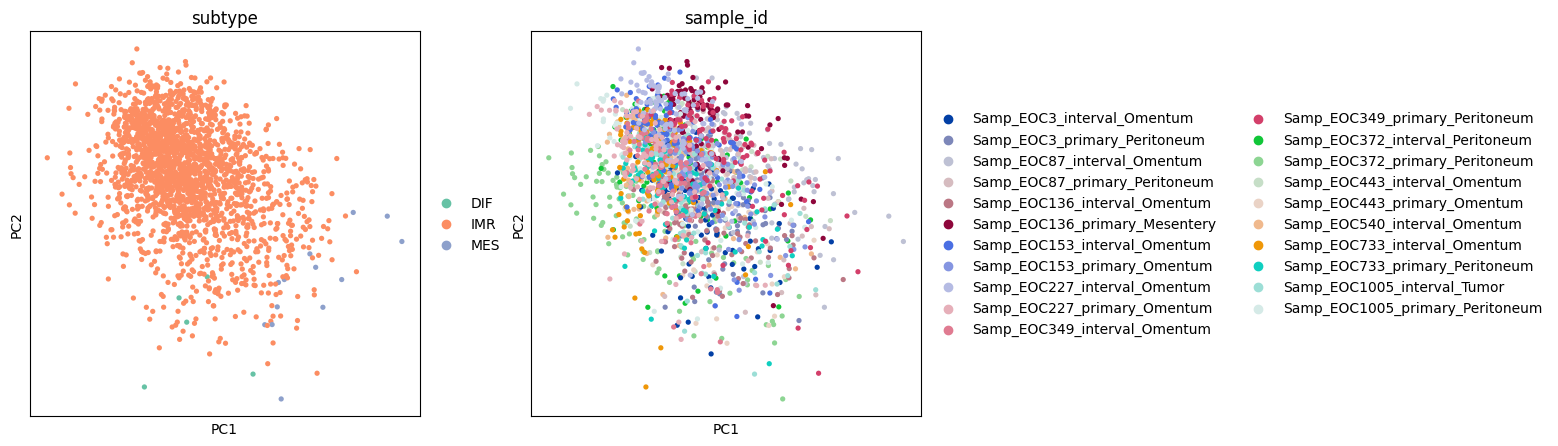

In [30]:
immune_ct = ["immune"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'])

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


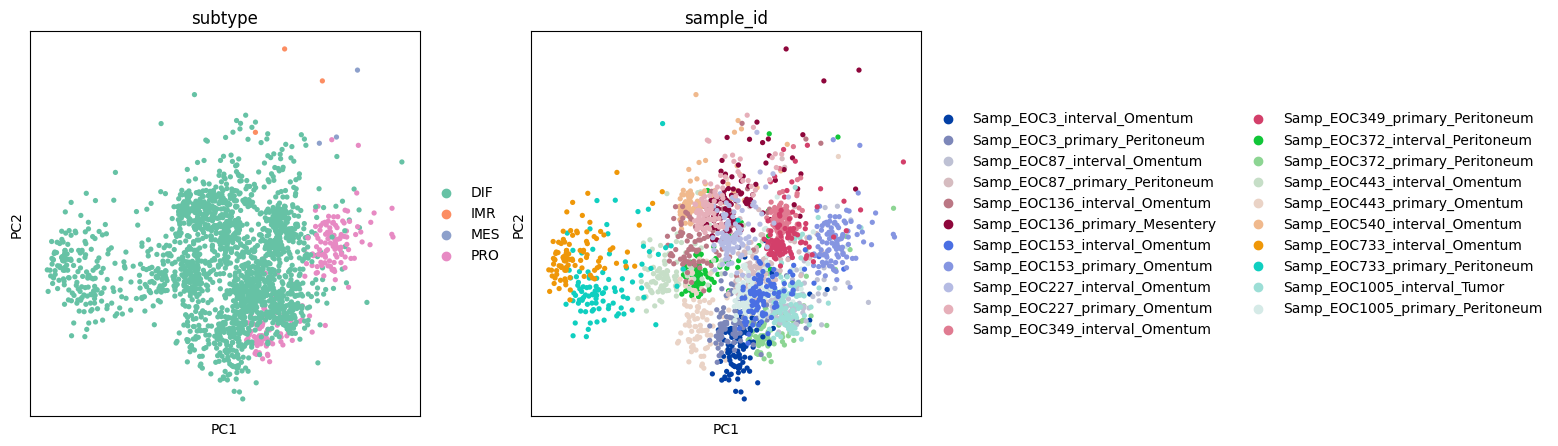

In [31]:
immune_ct = ["tumor"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'])

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


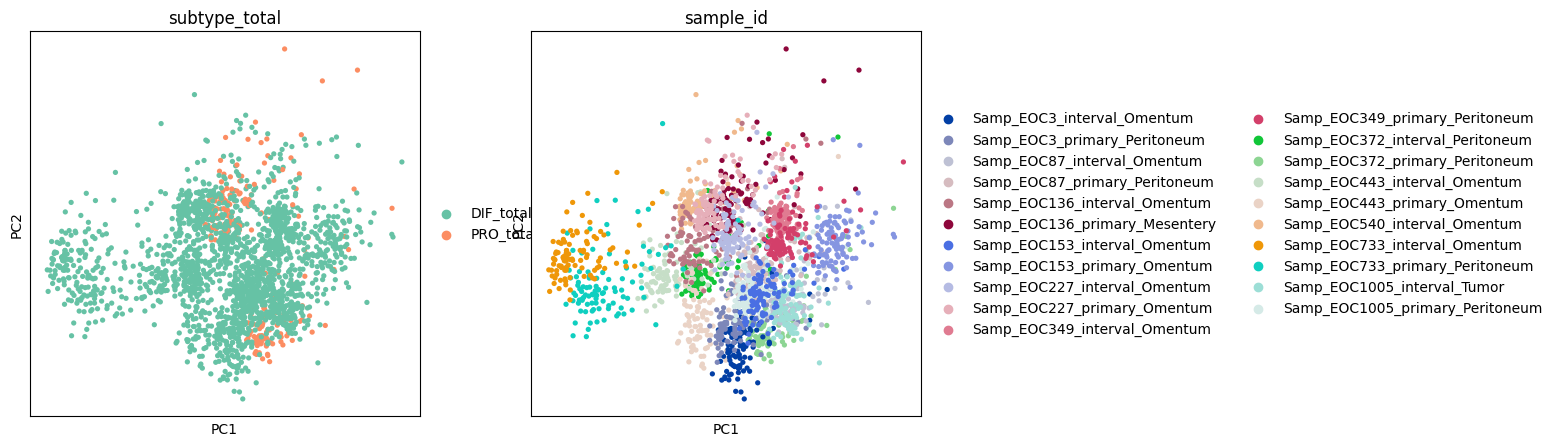

In [32]:
immune_ct = ["tumor"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype_total', 'sample_id'])

In [33]:
adata.obs.columns

Index(['sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type',
       'tumor', 'stromal', 'immune', 'IMR_consensus', 'DIF_consensus',
       'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'subtype_total'],
      dtype='object')

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


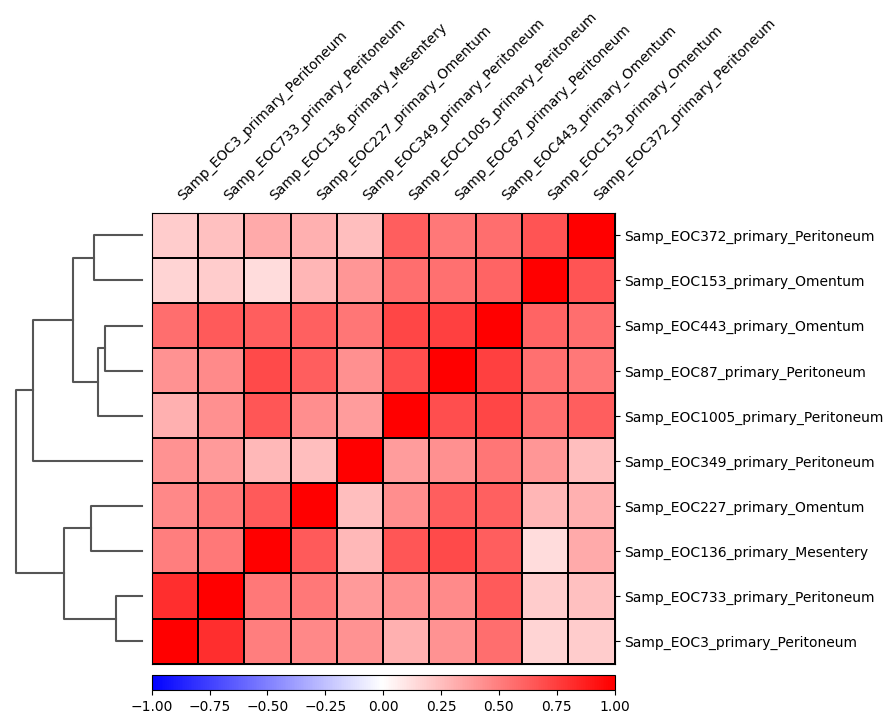

In [34]:
immune_ct = ["tumor"]
subtype_ct = ["DIF", "PRO"]

idx = np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") 
idx = np.logical_and(idx, adata.obs.sample_id.str.contains('primary')) 
idx = np.where(np.logical_and(idx, adata.obs.subtype.isin(subtype_ct)) )[0]

sc.pl.correlation_matrix(adata[idx], groupby="sample_id")

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


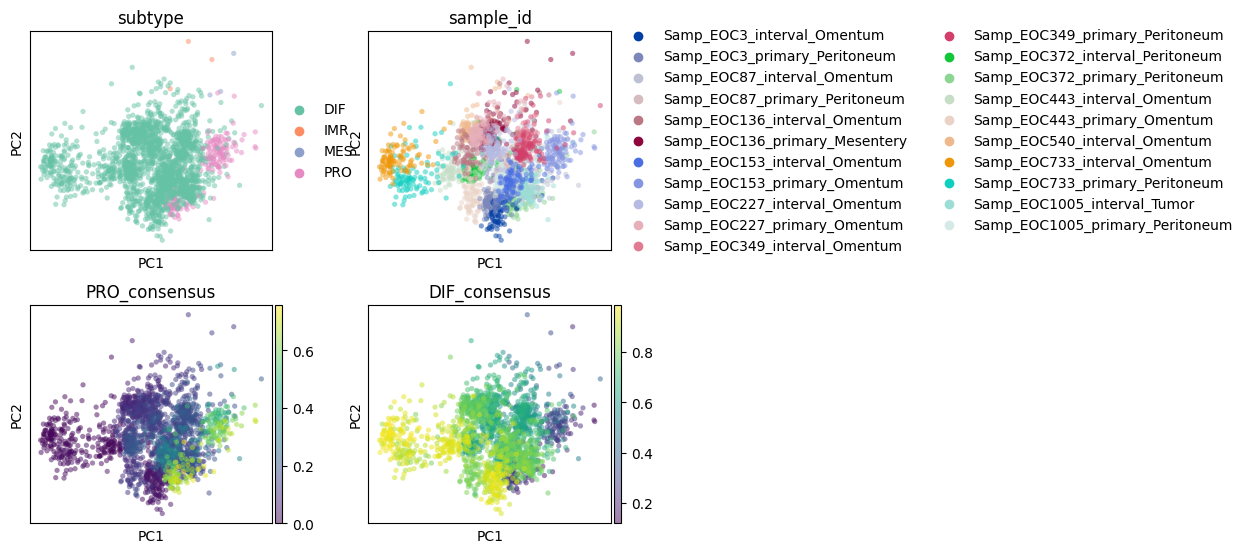

In [35]:
immune_ct = ["tumor"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id', "PRO_consensus", "DIF_consensus"], ncols=2, alpha=0.5)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


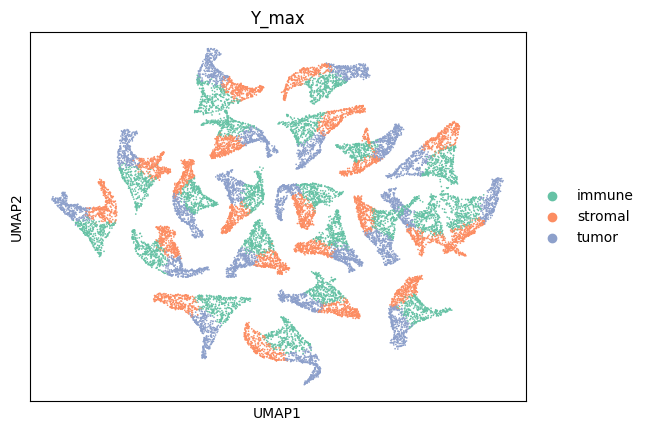

In [36]:
idx = np.where(adata.obs.cell_prop_type == "random" )[0]

sc.pl.umap(adata[idx], color='Y_max')